|   iter    |  target   | bootstrap | max_depth | max_fe... | min_im... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------------------
| 1         | -3.583    | 0.8701    | 7.076     | 0.5837    | 0.009296  | 1.822     | 2.352     | 84.25     |
| 2         | -4.701    | 0.4376    | 6.894     | 0.6101    | 0.02012   | 1.226     | 3.341     | 79.27     |
| 3         | -5.046    | 0.162     | 6.645     | 0.5978    | 0.03496   | 1.733     | 4.509     | 74.07     |
| 4         | -5.378    | 0.5165    | 5.681     | 0.7993    | 0.02571   | 2.118     | 2.103     | 86.0      |
| 5         | -5.08     | 0.421     | 6.059     | 0.5845    | 0.04501   | 2.339     | 3.368     | 64.49     |
| 6         | -4.521    | 0.5258    | 6.915     | 0.7236    | 0.04142   | 2.647     | 2.231     | 82.24     |
| 7         | -4.528    | 0.3093    | 6.67      | 0.7874    | 0.04416   | 1.591     | 3.537     | 54.44     |
| 8       

| 41        | -3.468    | 1.0       | 8.386     | 0.5       | 0.0       | 1.0       | 3.384     | 98.97     |
| 42        | -3.331    | 1.0       | 7.277     | 0.5       | 0.0       | 1.343     | 2.31      | 98.75     |
| 43        | -3.472    | 1.0       | 8.554     | 0.5       | 0.0       | 1.841     | 3.314     | 84.73     |
| 44        | -4.961    | 0.0       | 8.017     | 0.8       | 0.05      | 3.0       | 3.612     | 84.59     |
| 45        | -3.541    | 1.0       | 7.522     | 0.5       | 0.0       | 1.0       | 3.406     | 84.87     |
| 46        | -4.027    | 1.0       | 8.961     | 0.5       | 0.0       | 1.0       | 4.532     | 85.9      |
| 47        | -3.436    | 1.0       | 8.703     | 0.5       | 0.0       | 1.0       | 2.0       | 83.96     |
| 48        | -4.343    | 0.0       | 8.898     | 0.5       | 0.05      | 1.139     | 2.39      | 59.91     |
| 49        | -5.171    | 0.0       | 5.322     | 0.8       | 0.0       | 1.0       | 5.0       | 72.29     |
| 50      

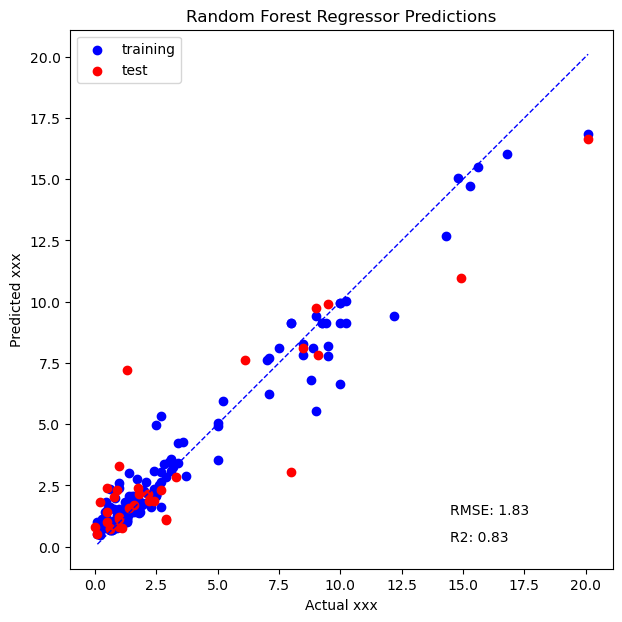

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization

# 读取数据
data = pd.read_excel('EL.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

# 定义目标函数
def rf_evaluate(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, min_impurity_decrease):
    params = {
        'n_estimators': int(n_estimators),
        'max_features': max_features,
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bootstrap > 0.5,
        'min_impurity_decrease': min_impurity_decrease
    }
    rf_model = RandomForestRegressor(**params, random_state=25)
    rf_model.fit(x_train, y_train)
    predictions = rf_model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    return -mse

# 定义超参数范围
param_bounds = {
    'n_estimators': (50, 100),  # 缩小范围
    'max_features': (0.5, 0.8),  # 缩小范围
    'max_depth': (3, 10),  # 缩小范围
    'min_samples_split': (2, 5),  # 缩小范围
    'min_samples_leaf': (1, 3),  # 缩小范围
    'bootstrap': (0, 1),
    'min_impurity_decrease': (0.0, 0.05)  # 缩小范围
}

# 进行贝叶斯优化
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=param_bounds,
    random_state=25,
    verbose=2
)
optimizer.maximize(init_points=20, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_features'] = best_params['max_features']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['bootstrap'] = best_params['bootstrap'] > 0.5
best_params['min_impurity_decrease'] = best_params['min_impurity_decrease']

# 输出最佳参数
print("Best parameters found by Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# 使用最佳参数训练最终模型
rf_model = RandomForestRegressor(**best_params, random_state=25)
rf_model.fit(x_train, y_train)

# 评价模型
rf_MSE = mean_squared_error(y_train, rf_model.predict(x_train))
rf_RMSE = np.sqrt(rf_MSE)
rf_R2 = r2_score(y_train, rf_model.predict(x_train))
print('RMSE_train: ' + str(rf_RMSE))
print('R2_train: ' + str(rf_R2))

rf_MSE_t = mean_squared_error(y_test, rf_model.predict(x_test))
rf_RMSE_t = np.sqrt(rf_MSE_t)
rf_R2_t = r2_score(y_test, rf_model.predict(x_test))
print('RMSE_test: ' + str(rf_RMSE_t))
print('R2_test: ' + str(rf_R2_t))

# 可视化结果
plt.figure(figsize=(7, 7))
plt.scatter(y_train, rf_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, rf_model.predict(x_test), c='red', label='test')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.xlabel('Actual xxx')
plt.ylabel('Predicted xxx')
plt.annotate(f'RMSE: {rf_RMSE_t:.2f}', xy=(0.7, 0.1), xycoords='axes fraction')
plt.annotate(f'R2: {rf_R2_t:.2f}', xy=(0.7, 0.05), xycoords='axes fraction')
plt.legend()
plt.title('Random Forest Regressor Predictions')
plt.show()


RMSE_train: 0.5872758407381521
R2_train: 0.9806917812007571
RMSE_test: 0.940413011924968
R2_test: 0.9400248472606764


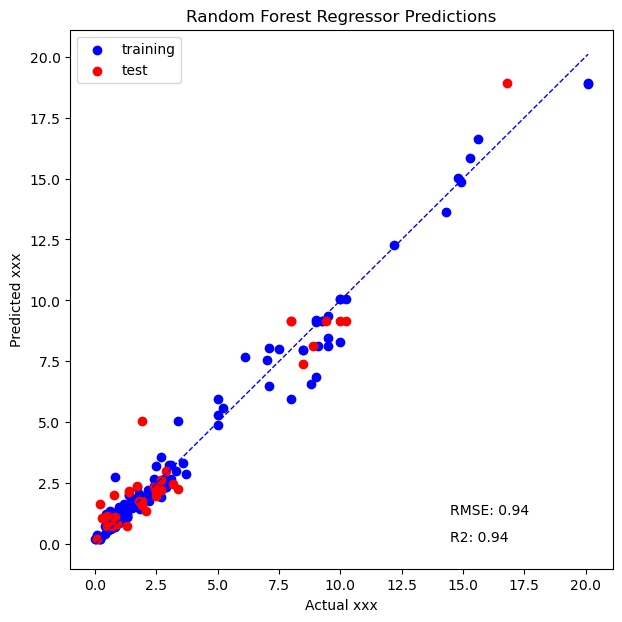

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 读取数据
data = pd.read_excel('EL.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

# 最佳参数
best_params = {
    'bootstrap': False,
    'max_depth': 10,
    'max_features': 0.5,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 55
}

# 使用最佳参数训练最终模型
rf_model = RandomForestRegressor(**best_params, random_state=25)
rf_model.fit(x_train, y_train)

# 评价模型
rf_MSE = mean_squared_error(y_train, rf_model.predict(x_train))
rf_RMSE = np.sqrt(rf_MSE)
rf_R2 = r2_score(y_train, rf_model.predict(x_train))
print('RMSE_train: ' + str(rf_RMSE))
print('R2_train: ' + str(rf_R2))

rf_MSE_t = mean_squared_error(y_test, rf_model.predict(x_test))
rf_RMSE_t = np.sqrt(rf_MSE_t)
rf_R2_t = r2_score(y_test, rf_model.predict(x_test))
print('RMSE_test: ' + str(rf_RMSE_t))
print('R2_test: ' + str(rf_R2_t))

# 准备导出数据
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': rf_model.predict(x_train),
    'Type': 'Train'
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': rf_model.predict(x_test),
    'Type': 'Test'
})
results = pd.concat([train_results, test_results])

# 导出到Excel文件
results.to_excel('nzelmodel_predictions.xlsx', index=False)

# 可视化结果
plt.figure(figsize=(7, 7))
plt.scatter(y_train, rf_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, rf_model.predict(x_test), c='red', label='test')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.xlabel('Actual xxx')
plt.ylabel('Predicted xxx')
plt.annotate(f'RMSE: {rf_RMSE_t:.2f}', xy=(0.7, 0.1), xycoords='axes fraction')
plt.annotate(f'R2: {rf_R2_t:.2f}', xy=(0.7, 0.05), xycoords='axes fraction')
plt.legend()
plt.title('Random Forest Regressor Predictions')
plt.show()
